# Análisis multidimensional del Bitcoin

### Índice por contenidos:

[1. Extracción, carga y transformación de las bases de datos:](#first)
- [1.1 El valor en USD del bitcoin a lo largo del tiempo](#firstfirst)
- [1.2 El Bitcoin en Twitter](#firstsecond)

[2. Estadística descriptiva: análisis de la importancia financiera del Bitcoin:](#second)
- [2.1 Volumen de negociación](#secondfirst)
- [2.2 Capitalización del mercado](#secondsecond)
- [2.3 Evolución de los precios](#secondthirst)
- [2.4 Regresión de Fibonacci](#secondfour)
- [2.5 Time Series Decomposition](#secondfive)

[3. Análisis de sentimiento en Twitter; correlación con el valor del Bitcoin](#thirst)

[4. Modelos de machine learning; análisis predicitivo del valor del Bitcoin.](#four)
- [4.1 Modelo ARIMA](#fourfirst)
- [4.2 Modelo XGBoost](#foursecond)

[5. Next Steps](#five)


**Importamos las librerias necesarias:**
- Exportar y manipular los datasets:

In [1]:
import pandas as pd
import numpy as np
import requests 

import warnings #para evitar cualquier warning
warnings.filterwarnings('ignore')

- Visualizaciones:

In [2]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from plotly.graph_objs import *

- Extracción de información de páginas web (scrapping):

In [3]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
PATH=ChromeDriverManager().install()   

[WDM] - Downloading: 100%|██████████| 6.58M/6.58M [00:02<00:00, 2.35MB/s]


### 1. Extracción, carga y transformación de las bases de datos: <a class="anchor" id="first"></a>

**1.1 El valor en USD del bitcoin a lo largo del tiempo** <a class="anchor" id="firstfirst"></a> 

Hacemos uso de scrapping con el software de Selenium debido a la dificultad de encontrar bases de datos completas y, sobre todo, al día. Haremos uso de una página que actualiza constantemente los precios lo que nos permitirá a futuro seguir jugando con datos actualizados al día. Automatizamos el proceso. Limpiamos los datos y los transformamos para asegurar su óptimo uso. Finalmente, se almacena en un archivo csv para un uso local y rápido.

In [4]:
driver = webdriver.Chrome(PATH)  
driver.get('https://coinmarketcap.com/es/currencies/bitcoin/historical-data/') 

In [5]:
# Quitamos las cookies y las recomendaciones # Utilizamos un try debido a que la página a veces carga o no una etiqueta de recomendaciones.
time.sleep(10)
try:
    driver.find_element("xpath", '//*[@id="cmc-cookie-policy-banner"]/div[2]').click()
    driver.find_element("xpath", '//*[@id="__next"]/div/div[3]/div[1]/div[2]/button[2]').click()
except:
    None

In [6]:
# Nos desplazamos en la página para que cargue la información que nos interesa:
html = driver.find_element(By.TAG_NAME,'html')
html.send_keys(Keys.PAGE_DOWN)
time.sleep(4)
html.send_keys(Keys.UP)

In [7]:
# Vamos a desplegar bastante información:
for i in range(60):
    driver.find_element("xpath", '/html/body/div[1]/div/div[1]/div[2]/div/div[3]/div/div/div[1]/p[1]/button').click()
    time.sleep(2)

In [8]:
baul = []
for i in driver.find_elements(By.TAG_NAME, "tbody"): # Guardamos la información.
    baul.extend(i.text.split())
    
driver.close() # Cerramos el driver.

In [9]:
# Puesta a punto de la columna que nos indica la fecha; date.

n=0
j=[]
date=[]
dateprov=[]

dateprov = [i for i in baul if "$" not in i]

for i in dateprov:
    if n < 2:
        j.append(i+"$")
        n +=1
    else:
        j.append(i)
        date.append("".join(j).replace("$", " "))
        j = []
        n = 0    

In [10]:
# Procedemos con las columnas restantes:
baul1 = [i for i in baul if "$" in i]

apertura = ["".join(baul1[i][1:].split(",")) for i in range(0, len(baul1), 6)]
maximo = ["".join(baul1[i][1:].split(",")) for i in range(1, len(baul1), 6)] 
minimo = ["".join(baul1[i][1:].split(",")) for i in range(2, len(baul1), 6)]   
cierre = ["".join(baul1[i][1:].split(",")) for i in range(3, len(baul1), 6)]
volumen = ["".join(baul1[i][1:].split(",")) for i in range(4, len(baul1), 6)]   
cap_mercado = ["".join(baul1[i][1:].split(",")) for i in range(5, len(baul1), 6)]   

In [11]:
# Construimos el dataframe:
dic_coin = {"Fecha" : date, "Apertura": apertura, 
             "Maximo" : maximo, "Minimo": minimo, 
             "Cierre": cierre, "Volumen": volumen, 
             "Capacidad de mercado": cap_mercado}

valor_bitcoin = pd.DataFrame(dic_coin)

In [12]:
valor_bitcoin.to_csv(r"C:\Users\jorge\BOOTCAMP\PROYECTO FINAL\data criptomonedas\valor_bitcoin.csv", index=False)

**1.2 El Bitcoin en Twitter** <a class="anchor" id="firstsecond"></a> 

Teniendo en cuenta que como criptomoneda gran parte de su precio se basa en el "hype" especulativo; es decir, como se empieza a esparcir la idea de que si se compra en tal momento se podrá en un futuro vender a un precio más alto. En este apartado trataremos de ver si se puede establecer una correlación entre los tweets y la subida o bajada del precio del Bitcoin.

Haremos uso de un csv con tweets recolectados por palabras clave; pasaremos a limpiar la base de datos (data cleaning) para ajustarla a nuestras necesidades. 

In [13]:
path = "C:/Users/jorge/BOOTCAMP/PROYECTO FINAL/"
root_tweet = "data criptomonedas/bitcoin_tweets10.csv"

In [14]:
bitcoin_twitter = pd.read_csv(path + root_tweet, encoding="latin")

In [15]:
bitcoin_twitter.duplicated().any() #comprobamos si hay duplicados en el dataset

True

In [16]:
bitcoin_twitter.drop_duplicates(inplace=True) #las eliminamos, probablemente sean filas vacías

In [17]:
bitcoin_twitter.isnull().mean()*100 #pasamos a comprobar las celdas vacías por columnas.

Unnamed: 0           0.000100
user_name            0.002500
user_location       46.332222
user_description    11.075634
user_created         0.000600
user_followers       0.000600
user_friends         0.000600
user_favourites      0.000900
user_verified        0.001000
date                 0.001100
text                 0.001300
hashtags             1.680690
source               0.337298
is_retweet           0.006000
cleanText            0.001900
Polarity Score       0.001800
sentiment            0.002000
dtype: float64

Nos deshacemos de las columnas que tienen un alto porcentaje de vacíos (+10%) y que juzgamos que tampoco son tan relevantes para el análisis.

In [18]:
nan_cols = bitcoin_twitter.isnull().mean()*100

In [19]:
bitcoin_twitter.drop(columns=nan_cols[nan_cols > 10].index, axis=1, inplace=True)

In [20]:
bitcoin_twitter.columns

Index(['Unnamed: 0', 'user_name', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'hashtags', 'source', 'is_retweet', 'cleanText', 'Polarity Score',
       'sentiment'],
      dtype='object')

In [21]:
bitcoin_twitter.drop(columns=["hashtags", "source", "user_verified", "Unnamed: 0", "sentiment", "user_created", "user_name", "Polarity Score" ], inplace = True)

In [22]:
bitcoin_twitter.head()

,user_followers,user_friends,user_favourites,date,text,is_retweet,cleanText
0,8534.0,7605,4838,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,False,blue ridge bank shares halted nyse bitcoin atm...
1,6769.0,1532,25483,2021-02-10 23:58:48,"ð Today, that's this #Thursday, we will do ...",False,today thursday take friend leowandersleb btc w...
2,128.0,332,924,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",False,guys evening read article btc would like share
3,625.0,129,14,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,False,btc big chance billion price bitcoin btc crypto
4,1249.0,1472,10482,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,False,network secured nodes today soon biggest bears...


In [23]:
date = []

for i in bitcoin_twitter.date:
    try:
        if len(i) == 19: date.append(i[:-9])
        else: date.append("inviable")
    except:
        date.append("inviable")

In [24]:
bitcoin_twitter.date = date

In [25]:
bitcoin_twitter.date.value_counts()

2021-08-09    53501
2021-06-22    45840
2021-07-23    43535
2021-06-21    41729
2021-07-21    38911
              ...  
2021-02-28     1634
2021-07-16     1110
2021-04-17      333
2021-03-11      217
inviable         20
Name: date, Length: 73, dtype: int64

In [26]:
bitcoin_twitter.drop(bitcoin_twitter[bitcoin_twitter.date == "inviable"].index, inplace=True)

In [27]:
bitcoin_twitter.to_csv(r"C:\Users\jorge\BOOTCAMP\PROYECTO FINAL\data criptomonedas\twitter_data.csv", index=False)

### 2. Estadística descriptiva: análisis de la importancia financiera del Bitcoin  <a class="anchor" id="second"></a> 

Pasamos a ver cómo se han distribuido los datos financieros más relevantes de la criptomoneda; volumen, capitalización de mercado y la evolución de los precios. Antes de eso traemos al csv guardado y procesamos los datos al formato deseado:

In [113]:
root_valor = "data criptomonedas/valor_bitcoin.csv"

In [114]:
valor = pd.read_csv(path + root_valor)

In [29]:
# Convertimos los tipos de datos de las columnas a un formato manipulable.
valor = valor_bitcoin.astype({"Apertura" : "float64", "Maximo" : "float64", "Minimo" : "float64", 
                                      "Cierre" : "float64", "Volumen" : "float64", "Capacidad de mercado" : "float64", 
                                      "Fecha" : "datetime64" })

In [30]:
# Añadimos una columna con la media de los precios; será útil para las visualizaciones.
valor["Media"] = (valor["Maximo"]+valor["Minimo"])/2

In [31]:
#Por motivos meramente estéticos, ordenamos las columnas:
valor = valor[['Fecha', 'Apertura', 'Maximo', 'Minimo', 'Cierre', 'Media', 'Volumen','Capacidad de mercado']]

In [32]:
valor = valor.sort_values(by = "Fecha").reset_index(drop=True)

In [33]:
valor

,Fecha,Apertura,Maximo,Minimo,Cierre,Media,Volumen,Capacidad de mercado
0,2017-11-19,7766.03,8101.91,7694.10,8036.49,7898.005,3.149320e+09,1.341242e+11
1,2017-11-20,8039.07,8336.86,7949.36,8200.64,8143.110,3.488450e+09,1.368818e+11
2,2017-11-21,8205.74,8348.66,7762.71,8071.26,8055.685,4.277610e+09,1.347397e+11
3,2017-11-22,8077.95,8302.26,8075.47,8253.55,8188.865,3.633530e+09,1.377979e+11
4,2017-11-23,8232.38,8267.40,8038.77,8038.77,8153.085,4.225180e+09,1.342279e+11
...,...,...,...,...,...,...,...,...
1851,2022-12-14,17782.07,18318.53,17739.51,17815.65,18029.020,2.553448e+10,3.426658e+11
1852,2022-12-15,17813.64,17846.74,17322.59,17364.86,17584.665,2.096445e+10,3.340105e+11
1853,2022-12-16,17364.55,17505.53,16584.70,16647.48,17045.115,2.403161e+10,3.202260e+11
1854,2022-12-17,16646.98,16800.59,16614.03,16795.09,16707.310,1.446358e+10,3.230790e+11


In [34]:
valor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1856 entries, 0 to 1855
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Fecha                 1856 non-null   datetime64[ns]
 1   Apertura              1856 non-null   float64       
 2   Maximo                1856 non-null   float64       
 3   Minimo                1856 non-null   float64       
 4   Cierre                1856 non-null   float64       
 5   Media                 1856 non-null   float64       
 6   Volumen               1856 non-null   float64       
 7   Capacidad de mercado  1856 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 116.1 KB


**2.1 Volumen de negociación**  <a class="anchor" id="secondfirst"></a> 

En los mercados financieros se interpreta "volume" o volumen, como el número de operaciones de compra-venta cerradas en un espacio determinado. Este indicador solo mide la cantitad de títulos negociados y no el dinero intercambiado.Por ende, a mayor número de titulos negociados, mayor es el interés por parte de los agentes para comprar o vender un activo.

En este apartado vamos a visualizar el volumen total de estos activos y el volumen generado año a año, pero para lograr una visualización eficaz, nos centraremos en los últimos años; a partir de mayo del 2019.

In [35]:
from datetime import datetime as dt 

rango = pd.date_range(start="2019-05-01", end= "2022-12-14") #dt.now().date()) # establecemos un rango hasta la fecha de hoy
valor_volumen = valor[valor["Fecha"].isin(rango)]

In [36]:
valor_volumen

,Fecha,Apertura,Maximo,Minimo,Cierre,Media,Volumen,Capacidad de mercado
528,2019-05-01,5350.91,5418.00,5347.65,5402.70,5382.825,1.367953e+10,9.550111e+10
529,2019-05-02,5402.42,5522.26,5394.22,5505.28,5458.240,1.464446e+10,9.733011e+10
530,2019-05-03,5505.55,5865.88,5490.20,5768.29,5678.040,1.872078e+10,1.019862e+11
531,2019-05-04,5769.20,5886.89,5645.47,5831.17,5766.180,1.756778e+10,1.031120e+11
532,2019-05-05,5831.07,5833.86,5708.04,5795.71,5770.950,1.480883e+10,1.024944e+11
...,...,...,...,...,...,...,...,...
1847,2022-12-10,17134.22,17216.83,17120.68,17128.72,17168.755,1.270678e+10,3.293893e+11
1848,2022-12-11,17129.71,17245.64,17091.82,17104.19,17168.730,1.412249e+10,3.289333e+11
1849,2022-12-12,17102.50,17212.56,16899.39,17206.44,17055.975,1.961758e+10,3.309150e+11
1850,2022-12-13,17206.44,17930.09,17111.76,17781.32,17520.925,2.663474e+10,3.419890e+11


In [37]:
valor_volumen.head().style.set_properties(subset=['Fecha','Volumen'], **{'background-color': 'skyblue'})

,Fecha,Apertura,Maximo,Minimo,Cierre,Media,Volumen,Capacidad de mercado
528,2019-05-01 00:00:00,5350.910000,5418.000000,5347.650000,5402.700000,5382.825000,13679528236.000000,95501110091.000000
529,2019-05-02 00:00:00,5402.420000,5522.260000,5394.220000,5505.280000,5458.240000,14644460907.000000,97330112147.000000
530,2019-05-03 00:00:00,5505.550000,5865.880000,5490.200000,5768.290000,5678.040000,18720780006.000000,101986240859.000000
531,2019-05-04 00:00:00,5769.200000,5886.890000,5645.470000,5831.170000,5766.180000,17567780766.000000,103112021259.000000
532,2019-05-05 00:00:00,5831.070000,5833.860000,5708.040000,5795.710000,5770.950000,14808830723.000000,102494420158.000000


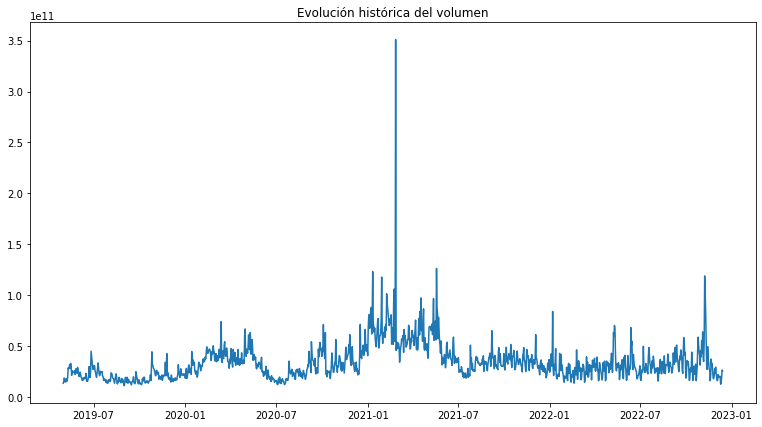

In [38]:
plt.figure(figsize=(13,7))
plt.title("Evolución histórica del volumen")
plt.plot(valor_volumen.Fecha, valor_volumen.Volumen);

**2.2 Capitalización del mercado** <a class="anchor" id="secondsecond"></a> 

La capitalización de mercado es el valor total que tiene una compañía en el mercado de valores y se obtiene de multiplicar el precio actual del instrumento financiero por el número titulos que hay en circulación. Dicho importe se suele usar por los agentes del mercado para la toma de decisiones acerca de los activos sobre los que invertir, ya que proporciona información relativa el tamaño de la entidad en comparación con otra.

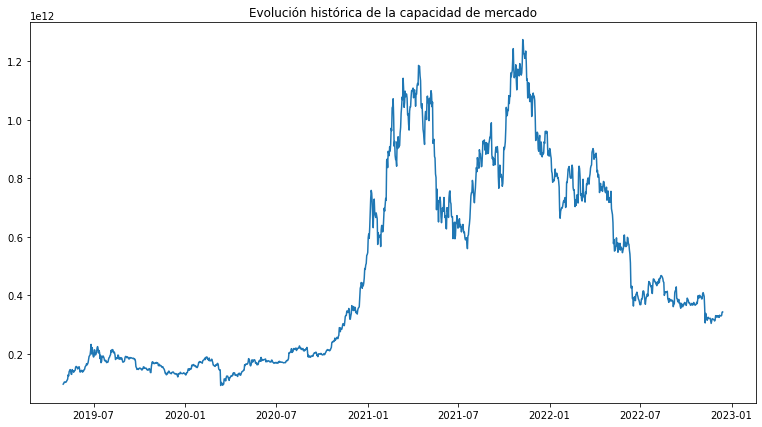

In [39]:
plt.figure(figsize=(13,7))
plt.title("Evolución histórica de la capacidad de mercado")
plt.plot(valor_volumen.Fecha, valor_volumen["Capacidad de mercado"]);

**2.3 Evolución de los precios** <a class="anchor" id="secondthirst"></a> 

"Open" refleja el precio con el que se comienza a negociar los activos financieros en los mercados de valores. "Close" es el último valor que se registra a la hora del cierre en los mercados financieros. "High" es el precio más alto registrado a lo largo del día en las cotizaciones y "Low" es el precio más bajo registrado a lo largo del día en las cotizaciones.

Definido ya que es cada precio observaremos como han evolucionado los precios de las diferentes criptomonedas a lo largo del periodo.

In [40]:
valor.head().style.set_properties(subset=['Apertura', "Media", "Cierre"], **{'background-color': "yellow"})

,Fecha,Apertura,Maximo,Minimo,Cierre,Media,Volumen,Capacidad de mercado
0,2017-11-19 00:00:00,7766.030000,8101.910000,7694.100000,8036.490000,7898.005000,3149319936.000000,134124196206.000000
1,2017-11-20 00:00:00,8039.070000,8336.860000,7949.360000,8200.640000,8143.110000,3488450048.000000,136881802624.000000
2,2017-11-21 00:00:00,8205.740000,8348.660000,7762.710000,8071.260000,8055.685000,4277609984.000000,134739693480.000000
3,2017-11-22 00:00:00,8077.950000,8302.260000,8075.470000,8253.550000,8188.865000,3633530112.000000,137797862084.000000
4,2017-11-23 00:00:00,8232.380000,8267.400000,8038.770000,8038.770000,8153.085000,4225179904.000000,134227860479.000000


In [41]:
#sns.set_theme(palette ="plotly_classic" ) #mirar kon alexis magno
trace1 = go.Scatter(
    x = valor['Fecha'],
    y = valor['Apertura'],
    mode = 'lines',
    name = 'Apertura',
)

trace2 = go.Scatter(
    x = valor['Fecha'],
    y = valor['Cierre'],
    mode = 'lines',
    name = 'Cierre',
)
trace3 = go.Scatter(
    x = valor['Fecha'],
    y = valor['Media'],
    mode = 'lines',
    name = 'Media',
)

layout = dict(
    title='Precios históricos del Bitcoin (2015-2022)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1, trace2, trace3]
fig = Figure(data=data, layout=layout)
fig.update_layout(hovermode="x unified")
iplot(fig, show_link= True, filename = "Precios históricos del Bitcoin (2015-2022)")

**2.4 Regresión de Fibonacci** <a class="anchor" id="secondfour"></a> 

In [42]:
%pip install pandas_datareader

Percentage level	 Price
0.00%		 67566.83
23.6		 52384.933
38.2%		 42992.743
50%		 35401.795
61.8%		 27810.847
100.00%		 3236.76


Text(0, 0.5, 'Precio cierre BTC')

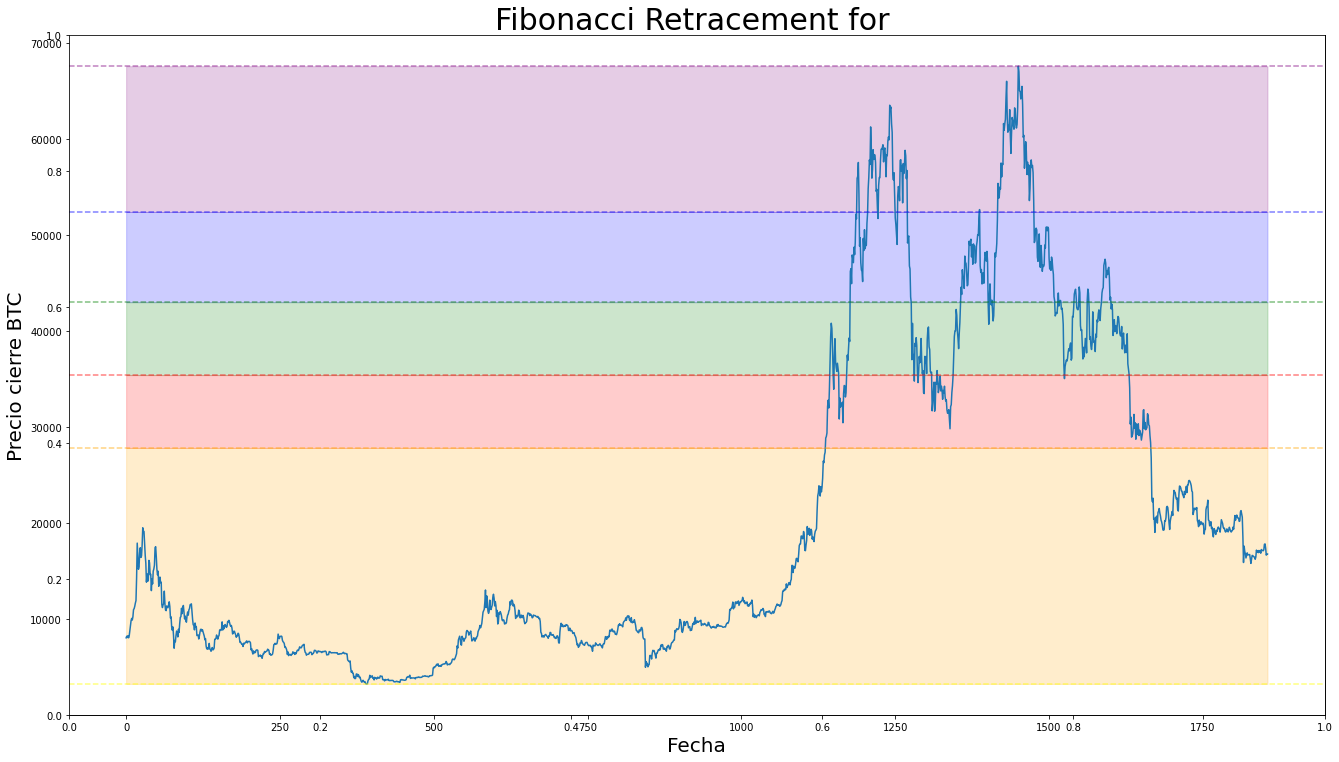

In [43]:
# Fetch data
end = dt.now().date()
valorf = valor[["Fecha", "Cierre"]]

# Fibonacci constants
max_value = valorf['Cierre'].max()
min_value = valorf['Cierre'].min()
difference = max_value - min_value

# Set Fibonacci levels
first_level = max_value - difference * 0.236
second_level = max_value - difference * 0.382
third_level = max_value - difference * 0.5
fourth_level = max_value - difference * 0.618

# Print levels
print('Percentage level\t Price')
print('0.00%\t\t', round(max_value, 3))
print('23.6\t\t', round(first_level, 3))
print('38.2%\t\t', round(second_level, 3))
print('50%\t\t', round(third_level, 3))
print('61.8%\t\t', round(fourth_level, 3))
print('100.00%\t\t', round(min_value, 3))

# Plot Fibonacci graph
plot_title = 'Fibonacci Retracement for '
fig = plt.figure(figsize=(22.5, 12.5))
plt.title(plot_title, fontsize=30)
ax = fig.add_subplot(111)
plt.plot(valorf.index, valorf['Cierre'])
plt.axhline(max_value, linestyle='--', alpha=0.5, color='purple')
ax.fill_between(valorf.index, max_value, first_level, color='purple', alpha=0.2)

# Fill sections
plt.axhline(first_level, linestyle='--', alpha=0.5, color='blue')
ax.fill_between(valorf.index, first_level, second_level, color='blue', alpha=0.2)

plt.axhline(second_level, linestyle='--', alpha=0.5, color='green')
ax.fill_between(valorf.index, second_level, third_level, color='green', alpha=0.2)

plt.axhline(third_level, linestyle='--', alpha=0.5, color='red')
ax.fill_between(valorf.index, third_level, fourth_level, color='red', alpha=0.2)

plt.axhline(fourth_level, linestyle='--', alpha=0.5, color='orange')
ax.fill_between(valorf.index, fourth_level, min_value, color='orange', alpha=0.2)

plt.axhline(min_value, linestyle='--', alpha=0.5, color='yellow')
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('Precio cierre BTC', fontsize=20)

Podemos ver que no guarda una estabilidad los precios, no tiene puntos de resistencia claros, es una divisa muy insegura.

**2.5 Time Series Decomposition** <a class="anchor" id="secondfive"></a> 

Hacemos una descomposición temporal de la evoluciós de los precios; en las que podremos ver los ciclos y la tendencia general.

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [45]:
cierre_descompose = valor[["Fecha", "Cierre"]]

In [46]:
#preparamos el dataframe. Convertimos la columna temporal en index.
cierre_descompose.set_index("Fecha", inplace=True)
cierre_descompose.sort_index(inplace=True)

In [47]:
result = seasonal_decompose(cierre_descompose['Cierre'], model='multiplicable', period=60)

Aquí estarían representados los ciclos estacionales a dos meses.

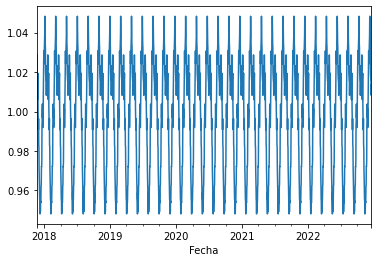

In [48]:
result.seasonal.plot();

Aquí mostraremos la tendencia:

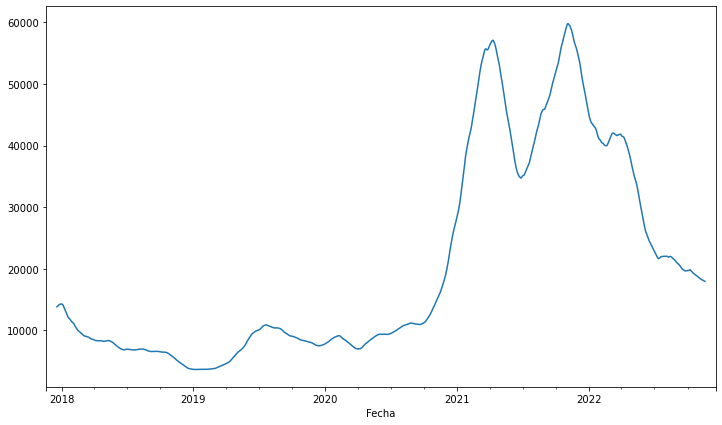

In [49]:
plt.figure(figsize=(12,7)) 
result.trend.plot();

Se puede ver el "boom" de los precios que obtuvo a finales del 2020 y su caída casi constante a lo largo del año 2022. Hay una clara tendencia a la baja.

<Figure size 1080x864 with 0 Axes>

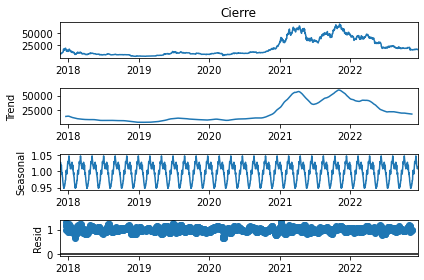

In [50]:
plt.figure(figsize=(15,12))
result.plot();

Aquí arriba hemos extraído una visualización completa donde también se aprecian los residuales, es decir, cómo se ajustarían los datos a una recta.

### 3. Análisis de sentimiento en Twitter; correlación con el valor del Bitcoin <a class="anchor" id="thirst"></a> 

Llamamos al dataframe de Twitter que arriba hemos limpiado, transformamos los datos al tipo necesario y tomamos una muestra:

In [51]:
bitcoin_twitter = pd.read_csv(r"C:\Users\jorge\BOOTCAMP\PROYECTO FINAL\data criptomonedas\twitter_data.csv", encoding="latin")

In [52]:
bitcoin_twitter.date = bitcoin_twitter.date.astype("datetime64")

In [53]:
#cogemos una muestra aleatoria de 25000 tweets:
sample_twitter = bitcoin_twitter.sample(n=25000, random_state=1)

In [54]:
sample_twitter.reset_index(inplace=True, drop=True)

**Análisis sentimiento**

Al dataframe que tenemos le aplicaremos VADER (Valence Aware Dictionary and sEntiment Reasoner); una herramienta de análisis de sentimientos basada en reglas y léxico que está específicamente en sintonía con los sentimientos expresados en las redes sociales.

In [55]:
! pip install vaderSentiment

In [56]:
import io
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import preprocessing

Limpiamos la data para que se ajuste a los paramétros que exige la herramienta de análisis para funcionar.

In [57]:
text_clean = []

for i, s in enumerate(sample_twitter.text):
    text = str(sample_twitter.loc[i, 'text'])
    text = text.replace("#", "") #eliminamos el #  
    text = re.sub("https?://(?:[-\w./]|(?:%[\da-fA-F]{2}))+", '', text, flags=re.MULTILINE) #reemplazamos con regex los "htpps", ""
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE) #quitamos las menciones
    text_clean.append(text)

sample_twitter.text = text_clean

In [58]:
analyzer = SentimentIntensityAnalyzer() #construimos el modulo de análisis

Acumulamos en una columna del dataframe la puntuación que nos ofrece la herramienta, que va desde el -1 (muy pesimista) al 1 (muy optimista), para luego organizar el dataframe haciendo un sumatorio por día de todas estas puntuaciones.

In [59]:
analyzer = SentimentIntensityAnalyzer()

compound = []
for i,s in enumerate(sample_twitter['text']):
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])

sample_twitter["compound"] = compound #la columna donde se almacena el resultado del análisis.
sample_twitter.head()

,user_followers,user_friends,user_favourites,date,text,is_retweet,cleanText,compound
0,75.0,422.0,101.0,2021-07-26,btc to the moon Ã°ÂÂÂÃ°ÂÂÂ 23468,False,btc moon,0.0000
1,180.0,67.0,1762.0,2021-07-26,Ã°ÂÂÂ &gt; Mining Rigs \n\n\n\n\nDogeBTC\nC...,False,simurghforever babybtcsimurgh therealdogebtc m...,0.0000
2,251.0,1595.0,6243.0,2021-08-09,"You want to buy, sell and/or store cryptomonai...",False,mcdonalds saweetie want buy sell store cryptom...,0.8464
3,39.0,523.0,347.0,2021-07-22,It's project so unique... I believe will be gr...,False,toshisharks luaswap project unique believe gro...,0.1779
4,1459.0,180.0,15894.0,2021-08-07,Dang Ethereum doge and btc are ALL on fire!,False,dang ethereum doge btc fire,-0.4003


Luego establecemos un score por cada tweet, no todos los tweets "pesan" igual, por ejemplo, no es lo mismo que sea twitteado por una cuenta con muchos seguidores e interacciones que por una que no; para ello tendremos en cuenta el numero de favoritos, si es retweet o no, y el número de seguidores.

In [60]:
score = []

for i, s in (sample_twitter.iterrows()):
    try:
        score.append(s["compound"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
        #establecemos el score; consiste en el nº de seguidores por la normalización entre favoritos y seguidores (vemos así la actividad que tienen sus tweets) por el retweet
    except:
        score.append(np.nan)
sample_twitter["score"] = score
sample_twitter.head(10)

,user_followers,user_friends,user_favourites,date,text,is_retweet,cleanText,compound,score
0,75.0,422.0,101.0,2021-07-26,btc to the moon Ã°ÂÂÂÃ°ÂÂÂ 23468,False,btc moon,0.0000,0.000000
1,180.0,67.0,1762.0,2021-07-26,Ã°ÂÂÂ &gt; Mining Rigs \n\n\n\n\nDogeBTC\nC...,False,simurghforever babybtcsimurgh therealdogebtc m...,0.0000,0.000000
2,251.0,1595.0,6243.0,2021-08-09,"You want to buy, sell and/or store cryptomonai...",False,mcdonalds saweetie want buy sell store cryptom...,0.8464,5263.949689
3,39.0,523.0,347.0,2021-07-22,It's project so unique... I believe will be gr...,False,toshisharks luaswap project unique believe gro...,0.1779,60.361470
4,1459.0,180.0,15894.0,2021-08-07,Dang Ethereum doge and btc are ALL on fire!,False,dang ethereum doge btc fire,-0.4003,-6358.410439
5,24257.0,0.0,3.0,2021-06-21,Bitcoin crackdown sends graphics cards prices ...,False,bitcoin crackdown sends graphics cards prices ...,0.0000,0.000000
6,74.0,219.0,271.0,2021-08-09,Ã°ÂÂÂÃ°ÂÂ¦Â Promising huge FEG project\nT...,False,ste_cha_feg fegtoken smallcappick dacryptorave...,0.8271,221.971584
7,1656.0,8.0,4.0,2021-05-25,The $BTC price is at $37830.07 right now.\nÃ°Â...,False,btc price right compared last tweet price drop...,0.2732,1.365176
8,262.0,13.0,307.0,2021-06-22,Bitcoin fell to the target of that triangle br...,False,bitcoin fell target triangle broken hourly cha...,-0.4767,-146.265335
9,77.0,687.0,9921.0,2021-07-03,Sophia robot is running on Blockchain.\n\nBitc...,False,sophia robot running blockchain bitcoin michae...,0.0000,0.000000


In [61]:
# analisis de sentimientos
sample_twitter = sample_twitter.drop_duplicates()
tweets = sample_twitter.copy() #realizamos una copia de seguridad
tweets['date'] = pd.to_datetime(tweets['date'],utc=True)
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']

tweets_grouped = tweets.resample('1h').sum()

In [62]:
valor1 = valor.copy() #hacemos copia de seguridad del dataframe Valor
tweets.index = tweets['date'] #convertimos los index en los días en los dos dataframes. Suele dar un resultado más óptimo.
valor1.index = valor["Fecha"]
tweets.drop(columns="date", inplace=True)
valor1.drop(columns="Fecha", inplace=True)

In [63]:
valor_grouped = valor1.resample('D')['Cierre'].mean() #agrupamos
tweets_grouped = tweets.resample('D').sum()

In [64]:
#establecemos el rango de fecha en ambos dataframes
inicio = tweets_grouped.index.min().replace(tzinfo=None)
final = tweets_grouped.index.max().replace(tzinfo=None)
tweets_grouped = tweets_grouped[inicio:final]
valor_grouped = valor_grouped[inicio:final]

Esta sería la representación del sentimiento acumulado y del precio de Bitcoin:

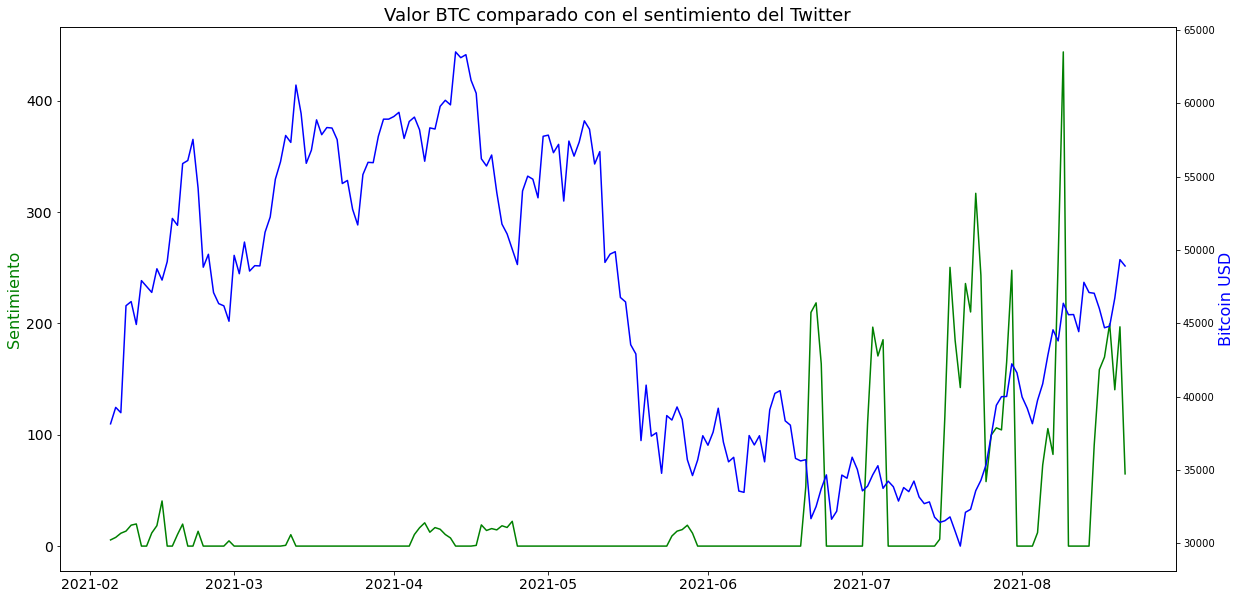

In [65]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Valor BTC comparado con el sentimiento del Twitter", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped.compound, 'g-')
ax2.plot_date(valor_grouped.index, valor_grouped, 'b-')

ax1.set_ylabel("Sentimiento", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin USD", color='b', fontsize=16)
plt.show()

Ahora probamos en vez de con el sentimiento simplemente, le metemos el score:

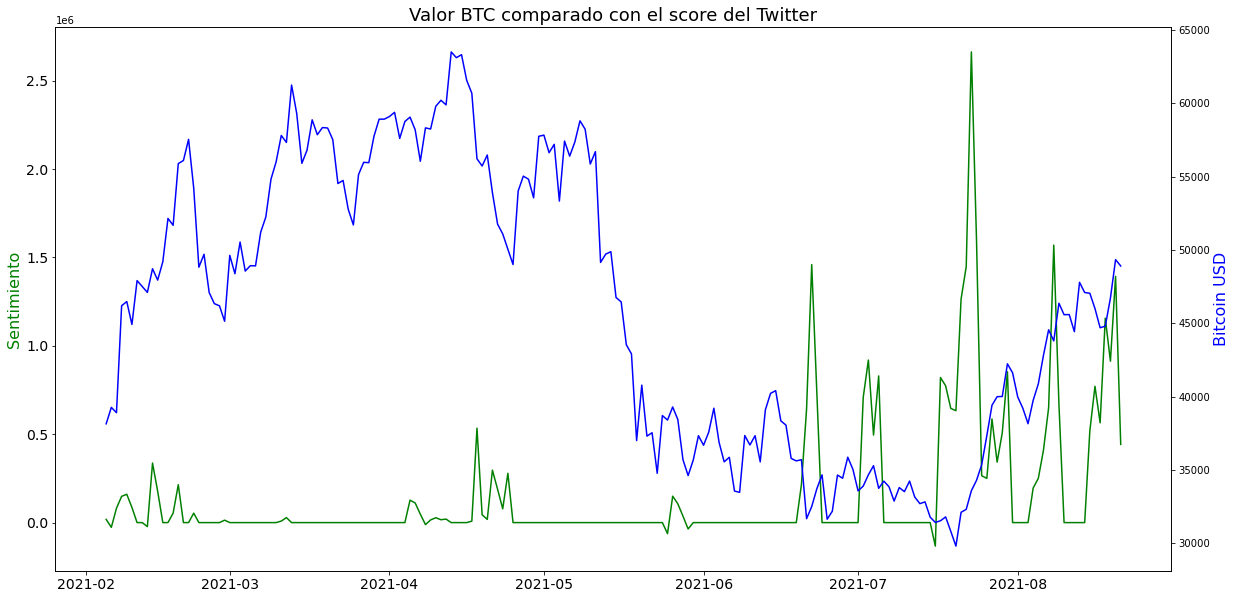

In [66]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Valor BTC comparado con el score del Twitter", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped.score, 'g-')
ax2.plot_date(valor_grouped.index, valor_grouped, 'b-')

ax1.set_ylabel("Sentimiento", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin USD", color='b', fontsize=16)
plt.show()

Aquí otro con la base de datos normalizados:

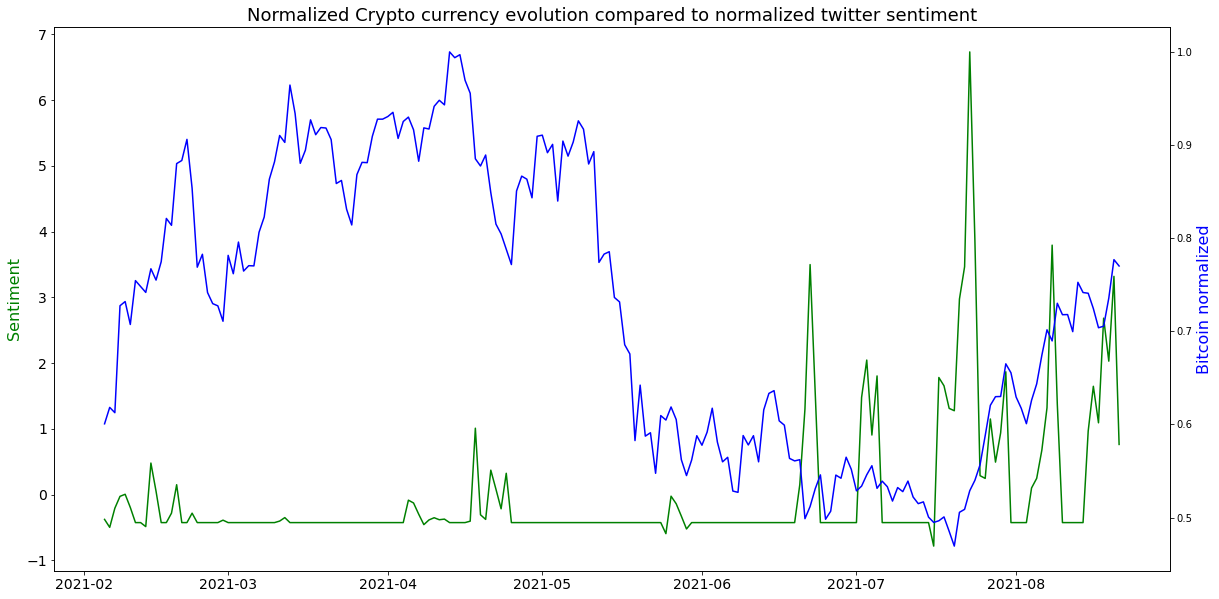

In [67]:
# Normalize time series data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
valor_grouped_scaled = valor_grouped / max(valor_grouped.max(), abs(valor_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(valor_grouped.index, valor_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()

No hay diferencia apreciable si se normaliza o no. Podemos decir que la base de datos es escasa y deficiente pero sí conjuga en algunos puntos la subida del "optimismo" y volumen de tweets con la subida del precio en algunos puntos. Nos abre un horizonte de exploración bastante interesante.

Aquí estarían las correlaciones:
Nos vienen a decir, básicamente, que hay un lag de 15 días. Es decir, que cuanto más score o sentimiento se acumula 15 días depues hay una correlación con la subida o bajada del precio.

In [68]:
def crosscorr(datax, datay, lag=0, method="pearson"): #esta función nos dará las correlaciones
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series de igual longitud
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']

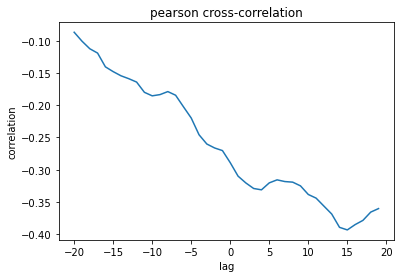

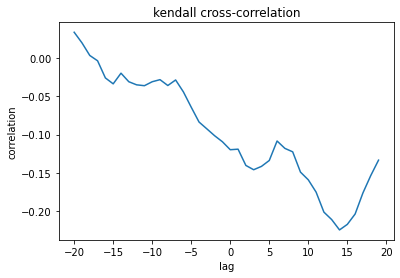

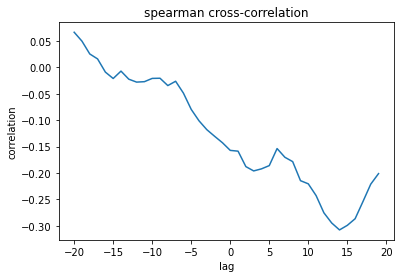

In [69]:
xcov = [crosscorr(tweets_grouped, valor_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, valor_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, valor_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### 4. Modelos de machine learning; análisis predicitivo del valor del Bitcoin. <a class="anchor" id="four"></a> 

**4.1 Modelo ARIMA** <a class="anchor" id="fourfirst"></a> 

O lo que es lo mismo, modelo autorregresivo integrado de media móvil, sirve para analizar o pronosticar series temporales estacionarias. En este caso no lo serán, pero con procedimientos matemáticos podemos hacer que sí sean estacionarias. El modelo ARIMA genera una serie temporal a partir de 3 parámetros (p,d,q) llamados órdenes del modelo ARIMA(p,d,q). Para encontrar los más cercanos tenemos que atender y procesar la data.

In [70]:
rango = pd.date_range(start="2019-05-01", end= dt.now().date()) # establecemos un rango hasta la fecha de hoy
data_arima = valor[valor["Fecha"].isin(rango)]
data_arima.index = data_arima["Fecha"].astype("datetime64")

In [71]:
data_arima.columns

Index(['Fecha', 'Apertura', 'Maximo', 'Minimo', 'Cierre', 'Media', 'Volumen',
       'Capacidad de mercado'],
      dtype='object')

In [72]:
data_arima.drop(columns = ['Fecha', 'Apertura', 'Maximo', 'Minimo', 'Media', 'Volumen',
       'Capacidad de mercado'], inplace = True )

In [73]:
from statsmodels.graphics.tsaplots import plot_acf

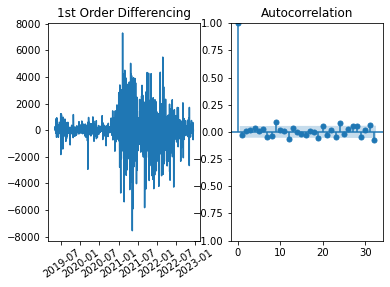

In [74]:
#aplicamos una diferenciación de primer orden
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(data_arima.Cierre.diff())
plt.xticks(rotation=35)

ax2 = fig.add_subplot(122)
plot_acf(data_arima.Cierre.diff().dropna(), ax = ax2);

Podemos ver que la única correlación entre la sucesión de datos es el dato con el dato anterior, por tanto, vamos a ver que correlación tendría con el dato en dos casillas anterior.

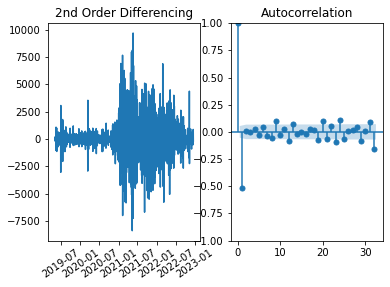

In [75]:
#aplicamos una diferenciación de segundo orden

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(data_arima.Cierre.diff().diff())
plt.xticks(rotation=35)

ax2 = fig.add_subplot(122)
plot_acf(data_arima.Cierre.diff().diff().dropna(), ax = ax2);

Sería buena.

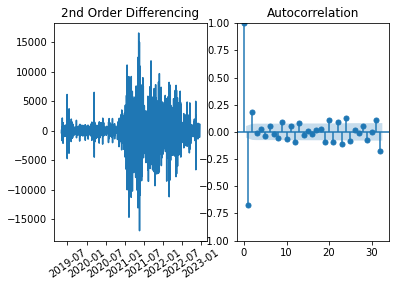

In [76]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(data_arima.Cierre.diff().diff().diff())
plt.xticks(rotation=35)

ax2 = fig.add_subplot(122)
plot_acf(data_arima.Cierre.diff().diff().diff().dropna(), ax = ax2);

Aqui sería con el 3er dato, estaría bien por el lado de la autocorrelación pero, en cuanto la diferencia, se nos excede. Nos quedamos con el grado 2.

Le pasamos ahora una función para sacar la "p" del parámetro de ARIMA, tenemos que buscar aquella que nos de un resultado por debajo del 0,05. Para ello utilizamos una función que nos prueba distintas posibilidades encuanto hace diferencia con los datos anteriores.

In [77]:
from statsmodels.tsa.stattools import adfuller #kiza solo meter esto y fuera
result = adfuller(data_arima.Cierre.dropna())
print("p-value:", result[1])

result = adfuller(data_arima.Cierre.diff().dropna())
print("p-value:", result[1])

result = adfuller(data_arima.Cierre.diff().diff().dropna())
print("p-value:", result[1])


p-value: 0.5768914651483774
p-value: 2.131612483481114e-18
p-value: 2.3621928759947495e-24


**Ajustamos los parámetros del algoritmo ARIMA**
Determinamos "p" en función del retraso más significativo en el gráfico de autocorrelación parcial. Podemos verificar la gráfica hasta una diferencia de segundo orden para estar seguros. En ambas parcelas, vemos que el primer retraso es el más significativo. Por lo tanto, consideramos que "p" es 1.

La p está por debajo del umbral 0,05, por tanto, consideramos que el valor "d", es decir, de la diferenciación, es de grado 2.

Finalmente, "q" se puede estimar de manera similar mirando la gráfica ACF en lugar de la gráfica PACF. Al observar la cantidad de retrasos que cruzan el umbral, podemos determinar cuánto del pasado sería lo suficientemente significativo como para considerarlo en el futuro. Los de alta correlación aportan más y serían suficientes para predecir valores futuros. De los gráficos anteriores, el parámetro de promedio móvil (MA) se puede establecer en 2.

Por lo tanto, nuestro modelo ARIMA final se puede definir como ARIMA(p=1, d=2, q= 2).

In [78]:
train_size = int(len(data_arima)*0.90)
train_data, test_data = data_arima[1:train_size], data_arima[train_size:(len(data_arima))]
train_data.shape, test_data.shape

((1194, 1), (133, 1))

In [79]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

arima_model = ARIMA(train_data, order=(1,2,2))
model = arima_model.fit()
print(model.summary())

C:\Users\jorge\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jorge\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jorge\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:                 Cierre   No. Observations:                 1194
Model:                 ARIMA(1, 2, 2)   Log Likelihood              -10159.290
Date:                Mon, 19 Dec 2022   AIC                          20326.579
Time:                        19:41:35   BIC                          20346.913
Sample:                    05-02-2019   HQIC                         20334.242
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9654      0.084     11.460      0.000       0.800       1.131
ma.L1         -1.9559      0.092    -21.376      0.000      -2.135      -1.777
ma.L2          0.9560      0.091     10.488      0.0

In [80]:
model.predict(dynamic=False)

2019-05-02        0.000000
2019-05-03     8258.391325
2019-05-04     7381.003414
2019-05-05     6956.653830
2019-05-06     6643.163307
                  ...     
2022-08-03    22967.307127
2022-08-04    22834.487708
2022-08-05    22616.973581
2022-08-06    23281.732353
2022-08-07    22950.514026
Freq: D, Name: predicted_mean, Length: 1194, dtype: float64

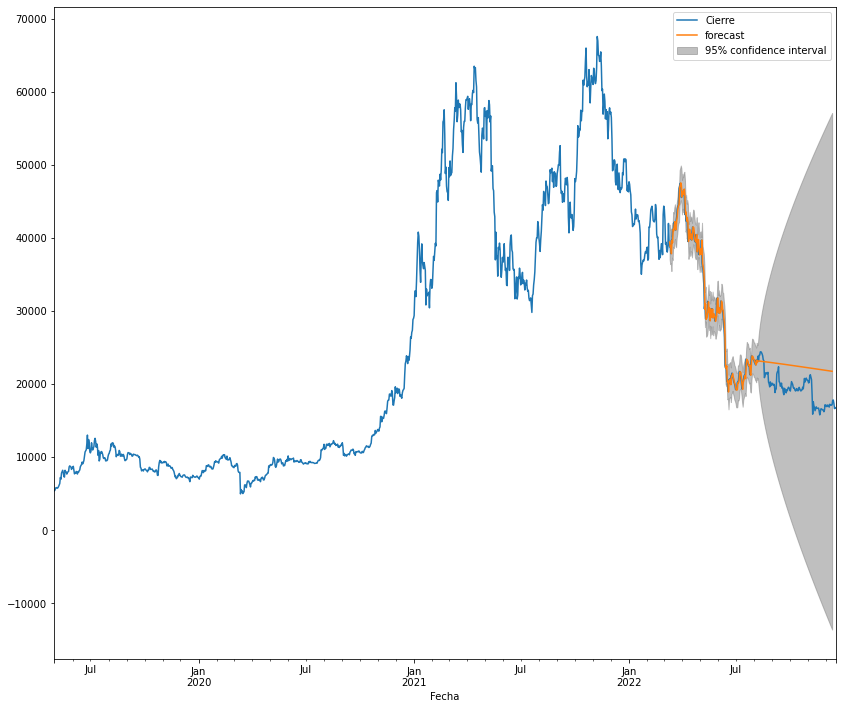

In [81]:
fig, ax = plt.subplots(figsize=(14, 12))
ax = data_arima.plot(ax=ax)
plot_predict(model, start = "2022-03-11", end= "2022-12-12", ax=ax);

No es significativa... capta la tendencia y sí que entra dentro del intervalo pero no nos vale. Queremos algo más certero.

**4.2 Modelo XGBoost** <a class="anchor" id="foursecond"></a> 

Probamos con otro algoritmo. Este parece ser más preciso, se basa en un modelo mejorado de los árboles de decisiones. 
Importamos librerías:


In [82]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from itertools import cycle

Seleccionamos un rango corto para el análisis; del 2021 al 2022.

In [84]:
rango = pd.date_range(start="2020-06-01", end=dt.now().date())
bitcoin_xg = valor[valor.Fecha.isin(rango)]

In [85]:
bitcoin_xg = bitcoin_xg.sort_values(by= "Fecha").reset_index(drop=True) #ordenamos

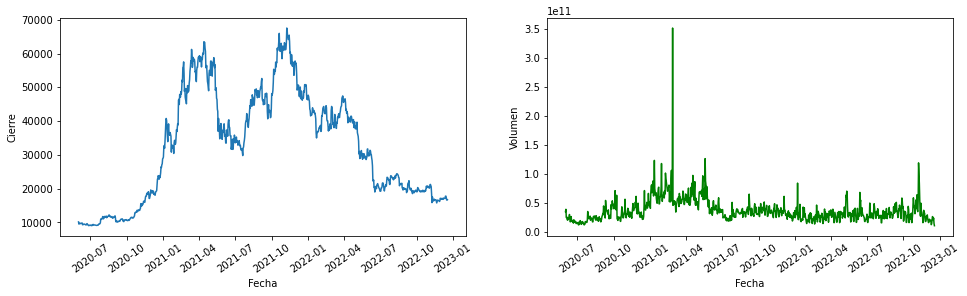

In [86]:
#visualizamos la evolución de la sección:
plt.figure(figsize = (16, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=bitcoin_xg, x="Fecha", y="Cierre")
plt.xticks(rotation=35)

plt.subplot(1, 2, 2)
sns.lineplot(data=bitcoin_xg, x="Fecha", y="Volumen", color="Green")
plt.xticks(rotation=35);

In [87]:
#preparamos el dataframe; #establecemos la seccion del dataframe que servirá para el modelo predictivo:
cierre_xg = bitcoin_xg[["Fecha", "Cierre"]]
cierre_xg_copy = cierre_xg.copy()

Normalizamos la data para hacer sufrir menos al algoritmo y garantizarnos una mayor precisión. Separamos la data training y la data testing:

In [88]:
#Normalizamos
del cierre_xg["Fecha"]
scaler = MinMaxScaler(feature_range=(0,1))
cierre_xg = scaler.fit_transform(np.array(cierre_xg).reshape(-1,1)) 

In [89]:
# separamos entre la data para el entrenamiento y la del test:
train_size_xg = int(len(cierre_xg)*0.70)
test_size_xg = len(cierre_xg) - train_size_xg
# una vez hemos establecido las dimensiones (un 70% para el train y un 30% para el test) las aplicamos:
train_data_xg, test_data_xg = cierre_xg[1:train_size_xg], cierre_xg[train_size_xg:(len(cierre_xg))]
train_data_xg.shape, test_data_xg.shape

((650, 1), (280, 1))

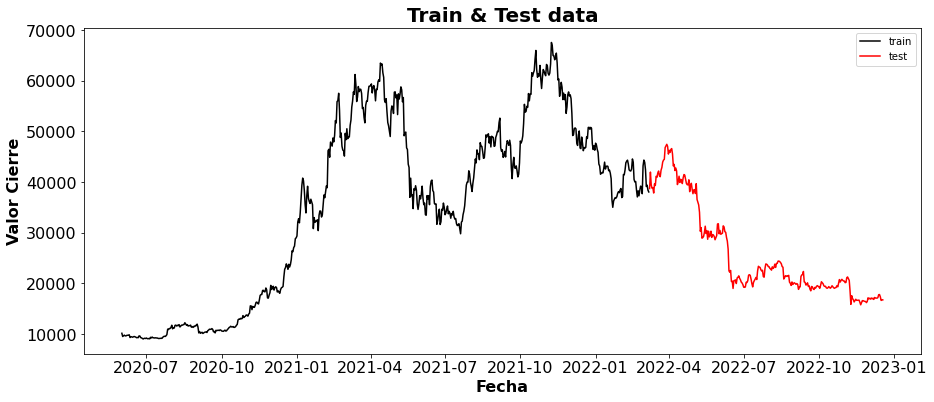

In [90]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = bitcoin_xg["Fecha"][:645], y = bitcoin_xg["Cierre"][:645], color = 'black')
sns.lineplot(x = bitcoin_xg["Fecha"][645:], y = bitcoin_xg["Cierre"][645:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Fecha', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Valor Cierre', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'));

In [91]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [92]:
time_step = 15
X_train, y_train = create_dataset(train_data_xg, time_step)
X_test, y_test = create_dataset(test_data_xg, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (634, 15)
y_train:  (634,)
X_test:  (264, 15)
y_test (264,)


Entrenamos el modelo predictivo:

In [93]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Este serían los índices de error. Teniendo en cuenta las escalas no esta nada mal:


In [94]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(np.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.05695580379960273
Root Mean squared Error - RMSE : 0.07372370924962399


In [95]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (634, 1)
Test data prediction: (264, 1)


In [96]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [97]:
look_back=time_step
trainPredictPlot = np.empty_like(cierre_xg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(cierre_xg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(cierre_xg)-2, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Precio original de cierre','Precio de cierre de entrenamiento','Predicción de precio de cierre'])

plotdf = pd.DataFrame({'Fecha': cierre_xg_copy['Fecha'],
                       'Cierre': cierre_xg_copy['Cierre'],
                      'Datos de entrenamiento': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'Datos predictivos': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Fecha'], y=[plotdf['Cierre'],plotdf['Datos de entrenamiento'],
                                          plotdf['Datos predictivos']],
              labels={'value':'Close price','Fecha': 'Fecha'})
fig.update_layout(title_text='Comparación entre el precio de cierre original y su predicción',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Precio cierre')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_layout(hovermode="x unified")
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (931, 1)
Test predicted data:  (931, 1)


Vamos más allá y nos arriesgamos con las predicciones a 10 días. Aquí veríamos los últimos 15 días y los próximos 10:

In [98]:
x_input=test_data_xg[len(test_data_xg)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = my_model.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = my_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [99]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [100]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(cierre_xg[len(cierre_xg)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Aquí sería toda la evolución histórica y la predicción:

In [101]:
my_model=cierre_xg.tolist()
my_model.extend((np.array(lst_output).reshape(-1,1)).tolist())
my_model=scaler.inverse_transform(my_model).reshape(1,-1).tolist()[0]

names = cycle(['Precio de cierre'])

fig = px.line(my_model,labels={'value': 'Precio de cierre','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## NEXT STEPS: análisis por país de la minería del Bitcoin relacionado con el gasto energético.  <a class="anchor" id="five"></a> 

Estas serían propuestas a futuro, no pude continuar por aquí principalmente por la dificultad de encontrar bases de datos gratuitas:

In [102]:
porcentaje_pais = pd.read_csv(r"C:\Users\jorge\BOOTCAMP\PROYECTO FINAL\data criptomonedas\pais porcentaje mineria.csv")

In [103]:
porcentaje_pais.sort_values(by="monthly_absolute_hashrate_EH/S", ascending=False).head(5)

,date,country,monthly_hashrate_%,monthly_absolute_hashrate_EH/S
120,2020-09-01,Mainland China,67.12%,91.10
130,2020-10-01,Mainland China,67.38%,88.92
110,2020-08-01,Mainland China,66.86%,82.71
100,2020-07-01,Mainland China,66.86%,81.71
50,2020-02-01,Mainland China,72.98%,80.59


In [104]:
porcentaje_pais.info() #vamos a pasar a Dtype float y datetime las columnas "monthly_hashrate_%" y "date" respectivamente

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            290 non-null    object 
 1   country                         290 non-null    object 
 2   monthly_hashrate_%              290 non-null    object 
 3   monthly_absolute_hashrate_EH/S  290 non-null    float64
dtypes: float64(1), object(3)
memory usage: 9.2+ KB


In [105]:
sin_porcentajes = [i[:-1] for i in porcentaje_pais["monthly_hashrate_%"]]
porcentaje_pais["monthly_hashrate_%"] = sin_porcentajes

In [106]:
#cambiamos los formatos de las columnas para facilitar las visualizaciones y su manipulación.
porcentaje_pais = porcentaje_pais.astype({"monthly_hashrate_%" : "float64", "date" : "datetime64" })

In [107]:
porcentaje_pais.dtypes

date                              datetime64[ns]
country                                   object
monthly_hashrate_%                       float64
monthly_absolute_hashrate_EH/S           float64
dtype: object

In [108]:
fig = px.area(porcentaje_pais, x="date", y="monthly_hashrate_%", color="country")
fig.show()

**(2.5) Extraemos el precio de minar un Bitcoin por pais**

Automatizamos el proceso haciendo uso de un driver de Chrome teniendo en cuenta que la tarea sería larga y tediosa si lo hacemos de forma manual.


In [109]:
driver = webdriver.Chrome(PATH)  
driver.get('https://www.visualcapitalist.com/cp/the-cost-of-mining-bitcoin-in-198-different-countries/') 

In [110]:
n = 0

while n < 19:
    if n == 0:
        paises = [i.text for i in driver.find_elements(By.CLASS_NAME, "column-2") if len(i.text) > 0][1:]
        coste = [i.text for i in driver.find_elements(By.CLASS_NAME, "column-3") if len(i.text) > 0][1:]
        beneficio = [i.text for i in driver.find_elements(By.CLASS_NAME, "column-4") if len(i.text) > 0][1:]

    driver.find_element("xpath", '//*[@id="tablepress-2438_next"]').click()
    
    paises_ = [i.text for i in driver.find_elements(By.CLASS_NAME, "column-2") if len(i.text) > 0][1:]
    coste_ = [i.text for i in driver.find_elements(By.CLASS_NAME, "column-3") if len(i.text) > 0][1:]
    beneficio_ = [i.text for i in driver.find_elements(By.CLASS_NAME, "column-4") if len(i.text) > 0][1:]
    
    paises.extend(paises_)
    coste.extend(coste_)
    beneficio.extend(beneficio_)
    n += 1
    
driver.close()    

Construimos el DataFrame para su posterior manipulación.

In [111]:
diccionario = {"Países": paises, "Coste por minar 1 Bitcoin": coste, "Beneficio por Bitcoin": beneficio}

coste_beneficio_pais = pd.DataFrame(diccionario)

In [112]:
coste_beneficio_pais

,Países,Coste por minar 1 Bitcoin,Beneficio por Bitcoin
0,Kuwait,"$1,393.95","$18,362.58"
1,Algeria,"$4,181.86","$15,574.67"
2,Sudan,"$4,779.27","$14,977.26"
3,Yemen,"$7,161.77","$12,594.76"
4,Ethiopia,"$7,168.91","$12,587.62"
...,...,...,...
193,Kiribati,"$82,243.29","-$62,486.76"
194,"Micronesia, Federated States Of","$82,442.43","-$62,685.90"
195,Antigua and Barbuda,"$89,412.20","-$69,655.67"
196,Solomon Islands,"$142,581.59","-$122,825.06"
